In [1]:
import tensorflow as tf
from keras import utils

Using TensorFlow backend.


In [2]:
url_dataset = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

## Preprocessing Images

In [2]:
import numpy as np
def clean(data):
    imgs = data.reshape(data.shape[0], 3, 32, 32)
    grayscale_imgs = img.mean(1)
    cropped_imgs = grayscale_imgs[:, 4:28, 4:28]
    img_data = cropped_imgs.reshape(data.shape[0], -1)
    img_size = np.shape(img_data)[1]
    means = np.mean(img_data, axis = 1)
    meansT = means.reshape(len(means), 1)
    stds = np.std(means, axis = 1)
    stdsT = stds.std(stds, axis = 1)
    adj_stds = np.maximum(stdsT, 1.0 / np.sqrt(img_size))
    normalized = (img_data - meansT) / adj_stds
    return normalized

## Import data

In [3]:
import pickle
import numpy as np

In [4]:
def unpickle(file):
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='latin-1')
    return data

In [6]:
def load_cifar_10_data(data_dir):
    train_data = None
    train_labels = []
    for i in range(1,6):
        data_dic = unpickle(data_dir + '/data_batch_{}'.format(i))
        if i == 1:
            train_data = data_dic['data']
        else:
            train_data = np.vstack((train_data, data_dic['data']))
        train_labels += data_dic['labels']
    
    test_data_dic = unpickle(data_dir + '/test_batch')
    test_data = test_data_dic['data']
    test_labels = test_data_dic['labels']
    
    train_data = train_data.reshape((len(train_data),3,32,32))
    train_data = np.rollaxis(train_data, 1, 4)
    train_labels = np.array(train_labels)
    
    test_data = test_data.reshape((len(test_data), 3, 32,32))
    test_data = np.rollaxis(test_data,1,4)
    test_labels = np.array(test_labels)
    
    return train_data, train_labels, test_data, test_labels

In [7]:
data_dir = 'dataset/cifar-10-batches-py/'
train_data, train_labels, test_data, test_labels = load_cifar_10_data(data_dir)

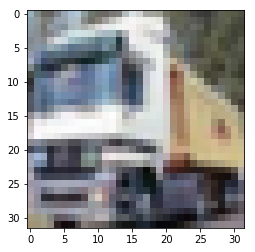

In [9]:
import matplotlib.pyplot as plt
plt.imshow(train_data[1, :,:,:])

In [10]:
# normalisasi data
train_data = train_data[:100, :, :, :].astype('float')
train_data = train_data[:100, :, :, :] / 255
test_data = test_data[:100, :, :, :].astype('float')
test_data = test_data[:100, :, :, :] / 255

In [11]:
# to_categorical
num_classes = 10
train_labels = train_labels[:100]
train_labels = utils.to_categorical(train_labels, num_classes)

test_labels = test_labels[:100]
test_labels = utils.to_categorical(test_labels, num_classes)

In [12]:
# print(train_labels.shape)

# Building CNN

In [13]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(100, 32, 32, 3)
(100, 10)
(100, 32, 32, 3)
(100, 10)


In [14]:
width = 32
height = 32
chn = 3
flat = width * height * chn

In [17]:
x = tf.placeholder(dtype=tf.float32, shape=[None, 32,32,3])
x_images = tf.reshape(x, shape=[-1, 32,32,3])

In [18]:
W_conv1 = tf.Variable(tf.truncated_normal([5,5,3,32], stddev=0.1))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32]))
convolve1 = tf.nn.conv2d(x_images, W_conv1, strides=[1,1,1,1], padding='SAME') + b_conv1
h_conv1 = tf.nn.relu(convolve1)
max_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

# conv2
W_conv2 = tf.Variable(tf.truncated_normal([5,5,32,64], stddev=0.1)) # W = filter
b_conv2 = tf.Variable(tf.constant(0.2, shape=[64]))
convolve2 = tf.nn.conv2d(max_pool1, W_conv2, strides=[1,1,1,1], padding='SAME') + b_conv2
h_conv2 = tf.nn.relu(convolve2)
max_pool2 = tf.nn.max_pool(h_conv2, ksize=[1,2,2,1], strides=[1,1,1,1], padding='SAME')

# flatten
out_flat = tf.reshape(max_pool2, [-1, 16*16*64])
# Fully connected layer
W_fc1 = tf.Variable(tf.truncated_normal([16*16*64, 1024]))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
fc_act = tf.nn.relu(tf.add(tf.matmul(out_flat, W_fc1), b_fc1))

# dropout
keep_prob = tf.placeholder(tf.float32)
dropout = tf.nn.dropout(fc_act, keep_prob)

# softmax
W_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
y_out = tf.nn.softmax(tf.add(tf.matmul(dropout, W_fc2), b_fc2))

# actual_valu
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [19]:
# cost = tf.nn.l2_loss(tf.reduce_sum(y_ * tf.log(y_out), reduction_indices=[1]))
# cost = tf.reduce_mean(tf.square(y_ - y_out))
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_out, labels=y_))
correct_prediction = tf.equal(tf.argmax(y_, axis = 1), tf.argmax(y_out, axis = 1))
accuracy_prediction = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

# backpropagation / minimize loss (cost)
train_step = tf.train.AdamOptimizer(1e-4).minimize(cost)

In [20]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
sess.run(y_out, feed_dict={x:train_data[:, :,:,:], y_:train_labels[:], keep_prob:0.5})

In [ ]:
hasil_pred = []
acc_res = []
loss_res = []
epochs = 100
new_cost = 0
for i in range(epochs):
#     if i % 100 == 0:
    for k in range(0, len(train_data), 20):
        if k % 20 == 0:
            sess.run(train_step, feed_dict={x:train_data[:, :, :, :], y_:train_labels[:], keep_prob:1.0})
            acc, loss, pred = sess.run([accuracy_prediction, cost, y_out],
                                      feed_dict={x:train_data[:,:,:,:], y_:train_labels[:], keep_prob:0.5})
            new_cost = abs(new_cost - loss)
            loss1 = round(loss,3)
            acc1 = round(acc,3)
            loss_res.append(new_cost)
            acc_res.append(acc)
            p = np.array(hasil_pred.append(pred)).flatten()
            print('iterasi # {}, loss : {}, akurasi : {}' .format(i, loss1, acc1))
# sess.close()

iterasi # 0, loss : 2.4110000133514404, akurasi : 0.05000000074505806
iterasi # 0, loss : 2.4200000762939453, akurasi : 0.03999999910593033
iterasi # 0, loss : 2.4179999828338623, akurasi : 0.03999999910593033
iterasi # 0, loss : 2.4210000038146973, akurasi : 0.03999999910593033
iterasi # 0, loss : 2.390000104904175, akurasi : 0.07000000029802322
iterasi # 1, loss : 2.372999906539917, akurasi : 0.09000000357627869
iterasi # 1, loss : 2.4010000228881836, akurasi : 0.05999999865889549
iterasi # 1, loss : 2.4010000228881836, akurasi : 0.05999999865889549
iterasi # 1, loss : 2.371000051498413, akurasi : 0.09000000357627869
iterasi # 1, loss : 2.390000104904175, akurasi : 0.07000000029802322
iterasi # 2, loss : 2.4000000953674316, akurasi : 0.05999999865889549
iterasi # 2, loss : 2.430999994277954, akurasi : 0.029999999329447746
iterasi # 2, loss : 2.4010000228881836, akurasi : 0.05999999865889549
iterasi # 2, loss : 2.4100000858306885, akurasi : 0.05000000074505806
iterasi # 2, loss : 2.39

In [30]:
np.argmax(pred, axis = 1).shape

(100,)

In [22]:
c = train_data.reshape([100* 32*32*3])
np.random.choice(c)

0.803921568627451

In [18]:
c.reshape([100, 32, 32, 3]).shape

(100, 32, 32, 3)

In [27]:
for i in range(10):
    print(i)

0
1
2
3
4
5
6
7
8
9
